# TP5 : Clustering

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_95638/3715480976.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Used librairies for this notebook :
- pandas version: 1.1.4
- numpy version: 1.19.4
- matplotlib version: 3.3.3
- scikit-learn version: 0.23.2

In [3]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)

pandas version: 2.2.0
numpy version: 1.26.3
matplotlib version: 3.8.2
scikit-learn version: 1.4.1.post1


# 0 - Data cleansing

## plot function

In [4]:
def plot_point_clouds(data, feature_x, feature_y, feature_label, 
                      title=None, legend=False, figsize=(5, 5)):
    """Plot point clouds.
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataframe with the point cloud values.
    feature_x : str
        Name of the feature to plot along the x-axis.
    feature_y : str
        Name of the feature to plot along the y-axis.
    feature_label : str
        Name of the feature to use to colorized the different clusters.
    title : str
        Title of the plot.
    legend : bool
        Display a legend or not.
    figsize : Tuple
        Tuple with two integers to set the plot size.
    
    """
    # get label names
    labels = list(set(data.loc[:, feature_label]))
    n = len(labels)
    
    # initialize plot
    plt.figure(figsize=figsize)
    
    # scatter plot for each label
    for i, label in enumerate(labels):
        data_label = data.loc[data.loc[:, feature_label] == label]
        x = data_label.loc[:, feature_x]
        y = data_label.loc[:, feature_y]
        if label == -1:
            plt.scatter(x, y, s=30, color="black", label=label)
        else:
            plt.scatter(x, y, s=30, cmap="Paired", label=label)
        
    # format axes and legend
    plt.xlabel(feature_x, fontweight="bold", fontsize=15)
    plt.ylabel(feature_y, fontweight="bold", fontsize=15)
    if title is not None:
        plt.title(title, fontweight="bold", fontsize=20)
    if legend:
        plt.legend(prop={'size': 15})
    plt.tight_layout()
    
    # end plot
    plt.show()
    plt.close()

## Ground truth data

Published in:

  - Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual
    dimorphism and environmental variability within a community of
    Antarctic penguins (genus *Pygoscelis*). PLoS ONE 9(3):e90081.
    <https://doi.org/10.1371/journal.pone.0090081>
    
https://github.com/allisonhorst/palmerpenguins. 

Here we use only part of the datset in the CSV file.

In [5]:
path = "./Clustering_dataset_penguin.csv"
df_penguin = pd.read_csv(path)
print(df_penguin.shape)
print(set(df_penguin.loc[:, "label"]))
df_penguin.head()

(344, 8)
{'chinstrap', 'adelie', 'gentoo'}


,species,label,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie Penguin (Pygoscelis adeliae),adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie Penguin (Pygoscelis adeliae),adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie Penguin (Pygoscelis adeliae),adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Or online/Colab

In [6]:
from palmerpenguins import load_penguins
df_penguin = load_penguins()
df_penguin.loc[:, "label"] = df_penguin.loc[:, "species"].str.lower()
print(df_penguin.shape)
print(set(df_penguin.loc[:, "label"]))
df_penguin.head()

(344, 9)
{'chinstrap', 'adelie', 'gentoo'}


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,label
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,adelie
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,adelie
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,adelie
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,adelie
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,adelie


/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


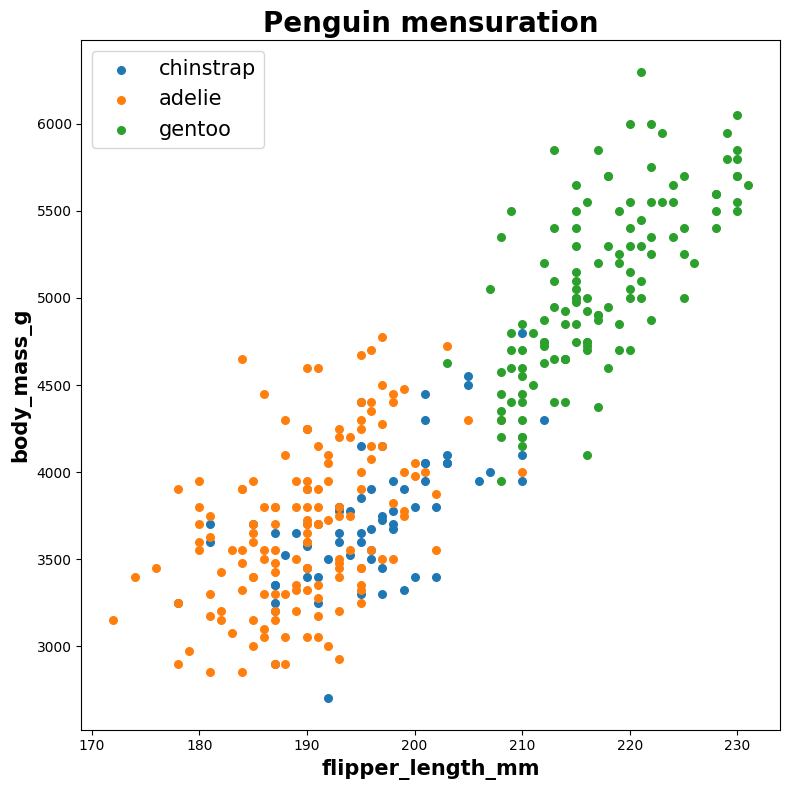

In [7]:
plot_point_clouds(data=df_penguin, 
                  feature_x="flipper_length_mm", 
                  feature_y="body_mass_g", 
                  feature_label="label",
                  title="Penguin mensuration",
                  legend=True,
                  figsize=(8, 8))

## Artificial data

We also use 4 artificial data sets with very distinct characteristics:
- A point cloud non-linearly separable into **concentric circles**.
- A point cloud composed of a **mixture of Gaussians** with different variances.
- An **anisotropic** point cloud (variance will depend on direction).
- A point cloud following a uniform distribution, **without underlying structure**.

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


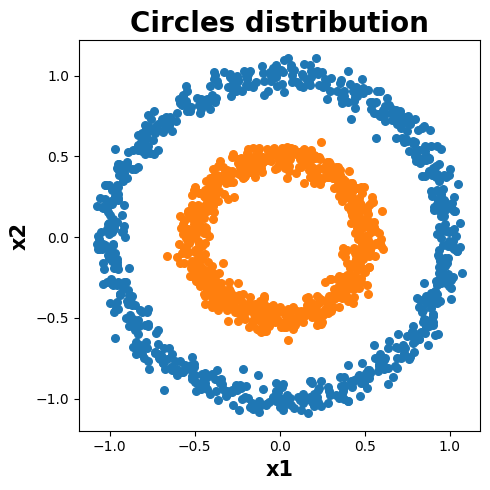

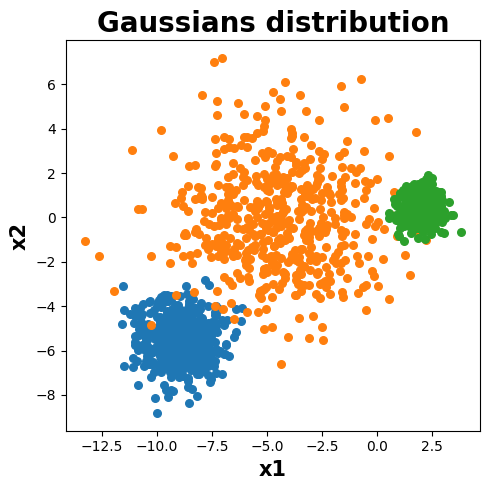

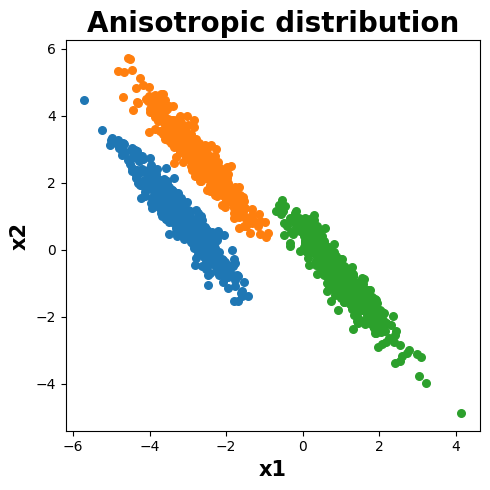

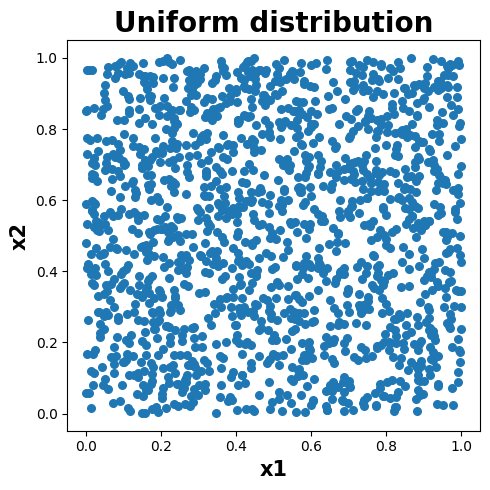

In [8]:
# parameters
random_state = 170
n_samples = 1500

# set random seed
np.random.seed(random_state)

### Circles ###
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
df_circles = pd.DataFrame({"x1": noisy_circles[0][:, 0],
                           "x2": noisy_circles[0][:, 1],
                           "label": noisy_circles[1]})
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Circles distribution")

### Blobs distribution ###
data, label = datasets.make_blobs(n_samples=n_samples, 
                                  cluster_std=[1.0, 2.5, 0.5], 
                                  random_state=random_state)
df_blobs = pd.DataFrame({"x1": data[:, 0],
                         "x2": data[:, 1],
                         "label": label})
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Gaussians distribution")

### Anisotropic distribution ###
data, label = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
data_aniso = np.dot(data, transformation)
df_aniso = pd.DataFrame({"x1": data_aniso[:, 0],
                         "x2": data_aniso[:, 1],
                         "label": label})
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Anisotropic distribution")

### Uniform distribution ###
uniform = np.random.rand(n_samples, 2)
label = np.zeros((n_samples,), dtype=np.int64)
df_uniform = pd.DataFrame({"x1": uniform[:, 0],
                           "x2": uniform[:, 1],
                           "label": label})
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Uniform distribution")

# 1 - Models

## K-mean clustering

k-means objective is to find $K$ clusters (and their centroid $\mu_k$) to **minimise the intra-cluster variance** :

\begin{align}
V = \sum_{k = 1}^{K} \sum_{x \in C_k} \frac{1}{|C_k|} (\|x - \mu_k\|^2)
\end{align}

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


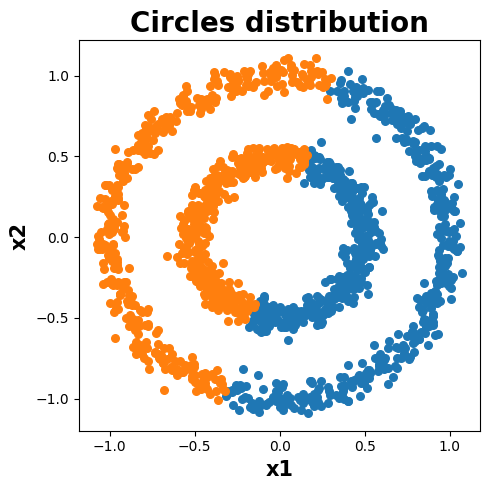

In [10]:
kmean = KMeans(
    n_clusters=2, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


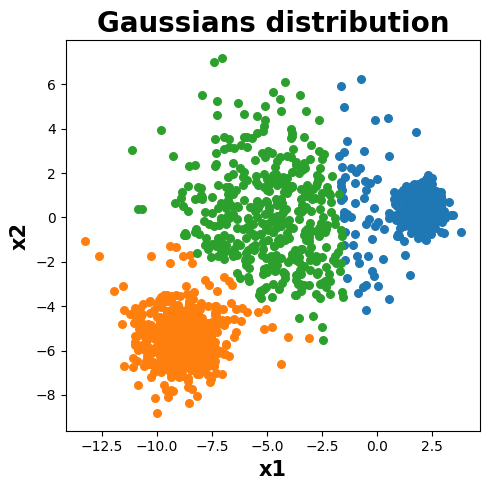

In [12]:
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


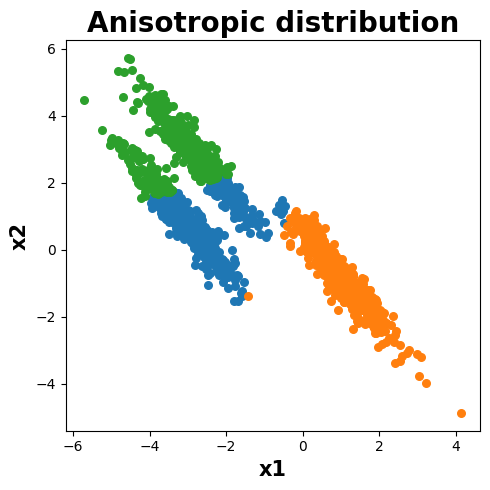

In [13]:
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

/home/jpldev/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1435: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(
/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


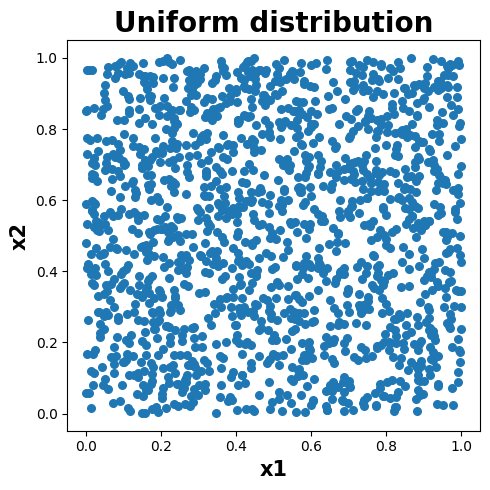

In [14]:
kmean = KMeans(
    n_clusters=1, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

We see that for some applications this works well but for others not. Let's see how to improve this.

## DBSCAN

The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm works in two stages:
- All sufficiently close observations are connected to each other.
- Observations with a minimum number of connected neighbors are considered *core samples*, from which clusters are extended. **All observations sufficiently close to a *core sample* belong to the same cluster as it**. 

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Translated with DeepL.com (free version)

/tmp/ipykernel_95638/3436147913.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 1 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_circles.loc[:, "cluster"] = dbscan.labels_
/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


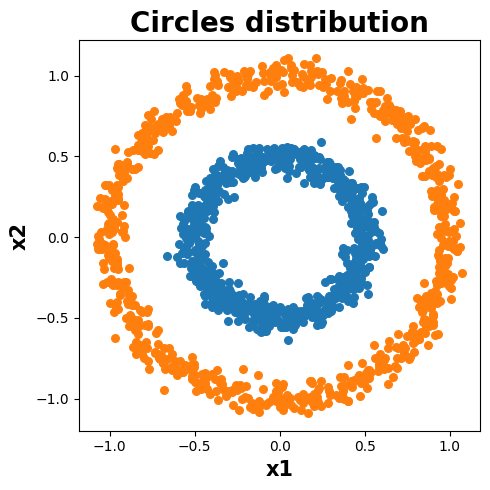

In [15]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

/tmp/ipykernel_95638/50953019.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 2 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_blobs.loc[:, "cluster"] = dbscan.labels_
/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


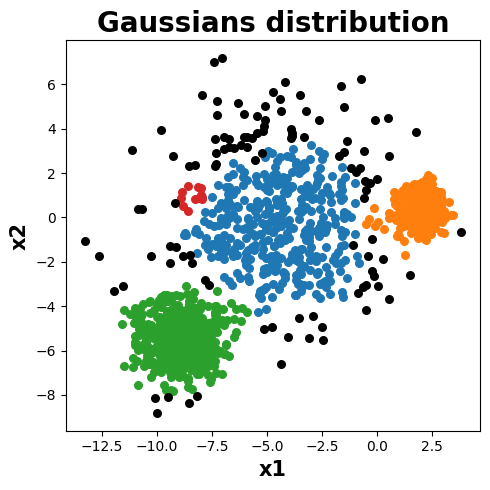

In [16]:
dbscan = DBSCAN(eps=0.7, min_samples=10)
dbscan.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

/tmp/ipykernel_95638/1638896090.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 2 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_aniso.loc[:, "cluster"] = dbscan.labels_
/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


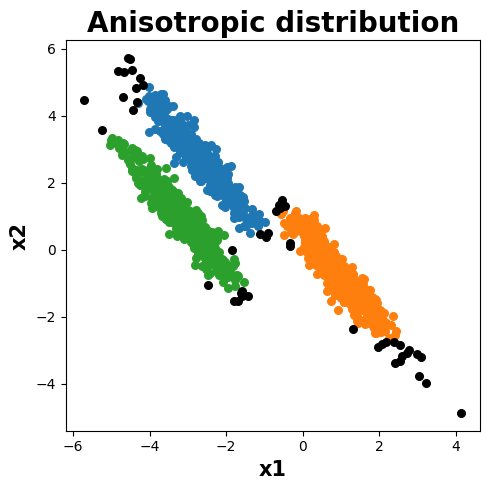

In [17]:
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

/tmp/ipykernel_95638/2514067773.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_uniform.loc[:, "cluster"] = dbscan.labels_
/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


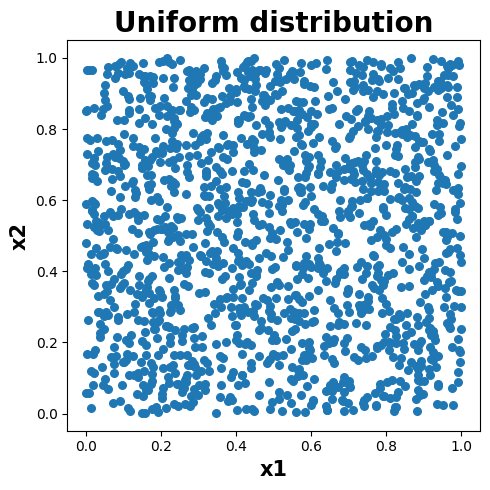

In [18]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

We see better results in some cases with DBSCAN but still not great for some examples. However it is worth mentionning that we do not have to specify the number of expected clusters for DBSCAN.

## Spectral clustering

Spectral clustering involves :
- building a **observation affinity matrix** by applying a kernel or k-nearest neighbor algorithm
- constructing a **normalized Laplacian matrix** from the affinity matrix
- project the Laplacian matrix into a **low-dimensional space using its eigenvectors**, and
- cluster** this space

The advantage of this method is that clusters with a non-convex structure can be found. The construction of the affinity matrix also allows great flexibility and reasoning on graphs.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

Translated with DeepL.com (free version)

/home/jpldev/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


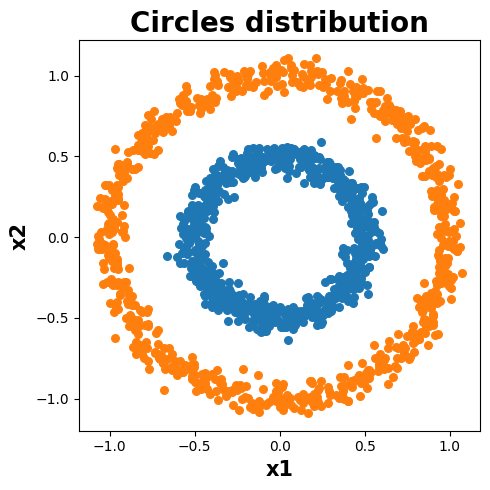

In [19]:
spectral = SpectralClustering(
    n_clusters=2, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=10)
spectral.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


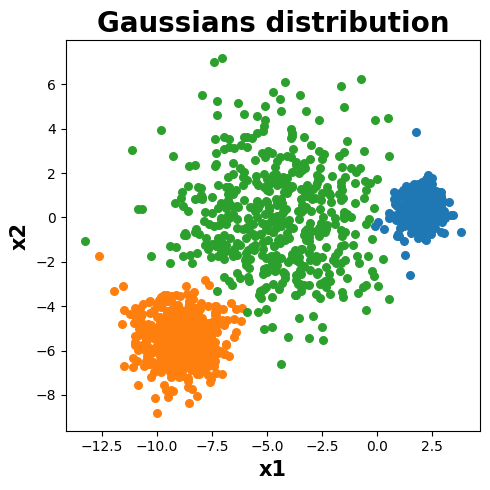

In [20]:
spectral = SpectralClustering(
    n_clusters=3, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=10)
spectral.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


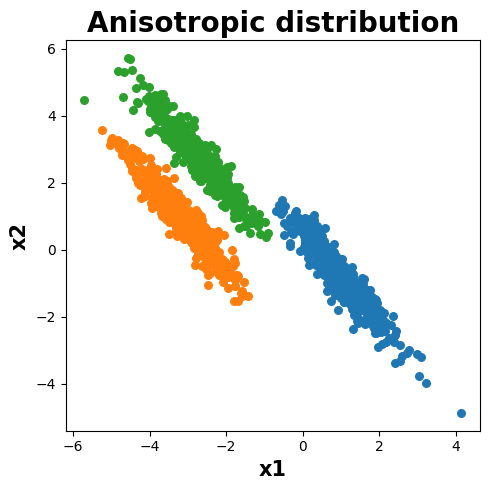

In [21]:
spectral = SpectralClustering(
    n_clusters=3, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=15)
spectral.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


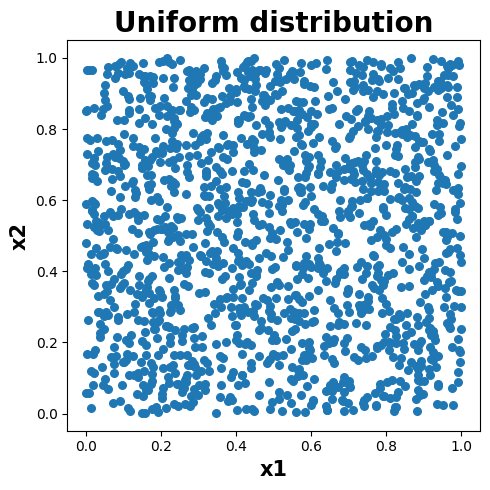

In [22]:
spectral = SpectralClustering(
    n_clusters=1, random_state=13, 
    n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10)
spectral.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

Here all the examples are working pretty well

## Gaussian mixture model

The Gaussian mixture model seeks to **optimize the parameters of a finite number of Gaussians** to the data. Scikit-learn's impémentation uses an Expectation-Maximization (EM) algorithm to converge the model.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


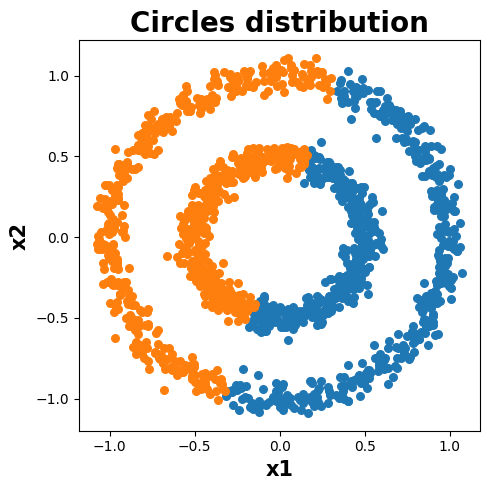

In [23]:
gmm = GaussianMixture(
    n_components=2, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = gmm.predict(df_circles.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


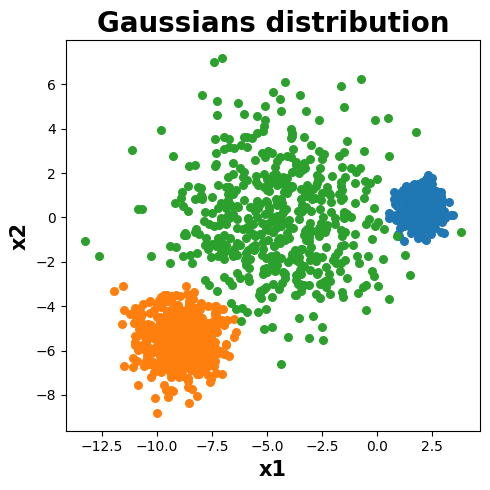

In [24]:
gmm = GaussianMixture(
    n_components=3, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = gmm.predict(df_blobs.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


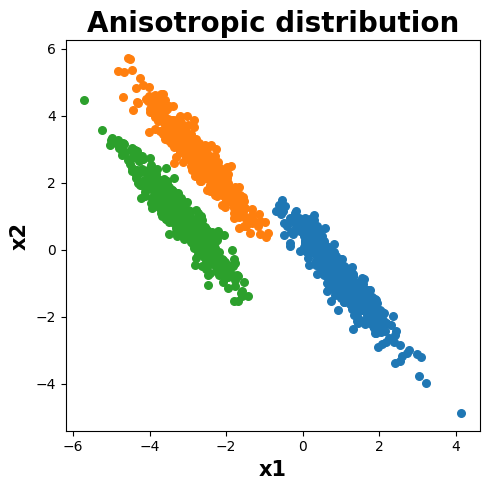

In [25]:
gmm = GaussianMixture(
    n_components=3, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = gmm.predict(df_aniso.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


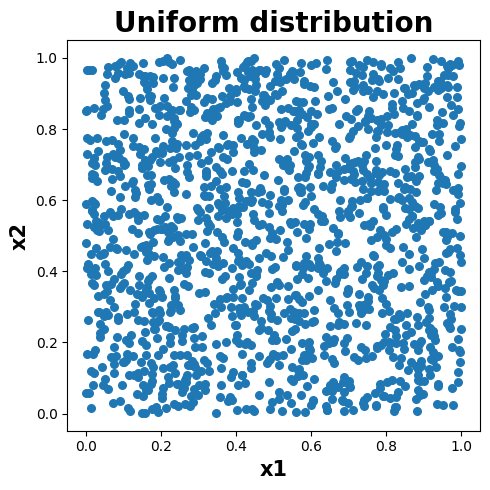

In [26]:
gmm = GaussianMixture(
    n_components=1, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = gmm.predict(df_uniform.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

# 2 - Clusters evaluation

## Silhouette scores

The silhouette coefficient (or score) is used to **comparison average distances within and between clusters** :

\begin{align}
\text{score} = \frac{b - a}{\max(a, b)}
\end{align}

with $a$ the average intra-cluster distance and $b$ the distance from a point to the nearest foreign cluster. The score is calculated per observation (with a value between -1 and 1) and then averaged to assess the clustering of the point cloud as a whole.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


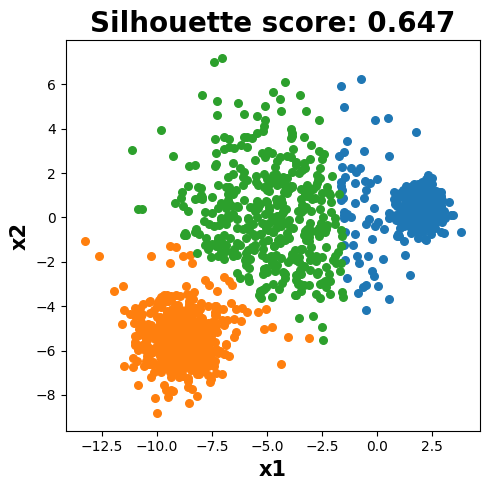

In [28]:
# clustering
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])

# update dataframe clusters
df_blobs.loc[:, "cluster"] = kmean.labels_

# compute silhouette score
score = silhouette_score(
    df_blobs.loc[:, ["x1", "x2"]], 
    labels=df_blobs.loc[:, "cluster"], 
    random_state=13)

# plot
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Silhouette score: {0:0.3f}".format(score))

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


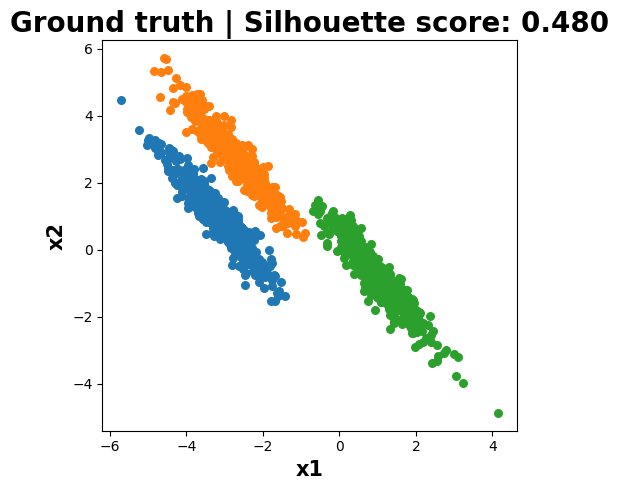

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


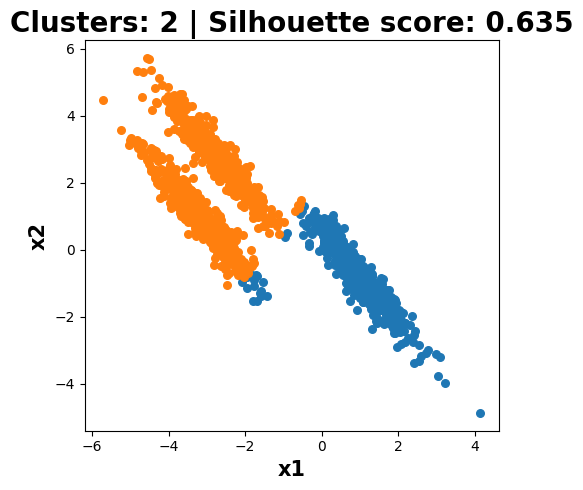

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


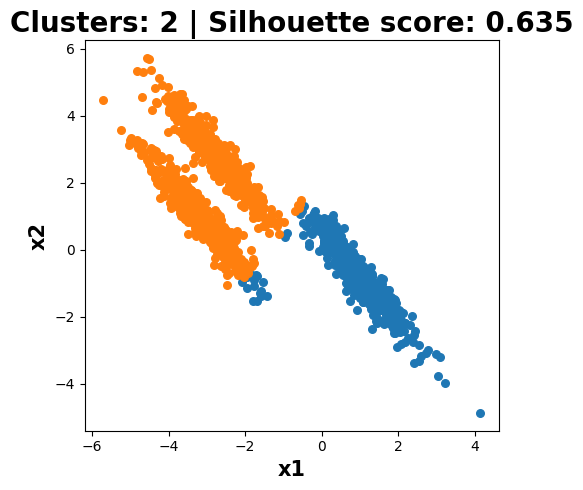

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


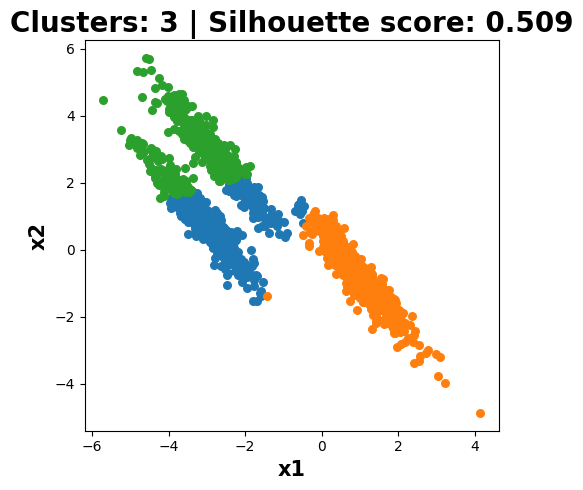

In [30]:
# score ground truth
score = silhouette_score(
    X=df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "label"], 
    random_state=13)
title = "Ground truth | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title=title)

# score 2 clusters
kmean = KMeans(
    n_clusters=2, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = kmean.labels_
score = silhouette_score(
    X=df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)
title = "Clusters: 2 | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title=title)


# score 2 clusters
kmean = KMeans(
    n_clusters=2, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_aniso.loc[:, ["x1", "x2"]])
# update dataframe clusters
df_aniso.loc[:, "cluster"] = kmean.labels_
# compute silhouette score
score = silhouette_score(
    df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)
title = "Clusters: 2 | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title=title)


# score 3 clusters
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = kmean.labels_
score = silhouette_score(
    X=df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)
title = "Clusters: 3 | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title=title)

## Silhouette plot

In addition to the silhouette score, you can display the score for each observation and **view the *silhouette* of clusters**.

Documentation: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

**Code:** Adapt the code below to display the silhouette graph for Gaussian data clustered with k-means.

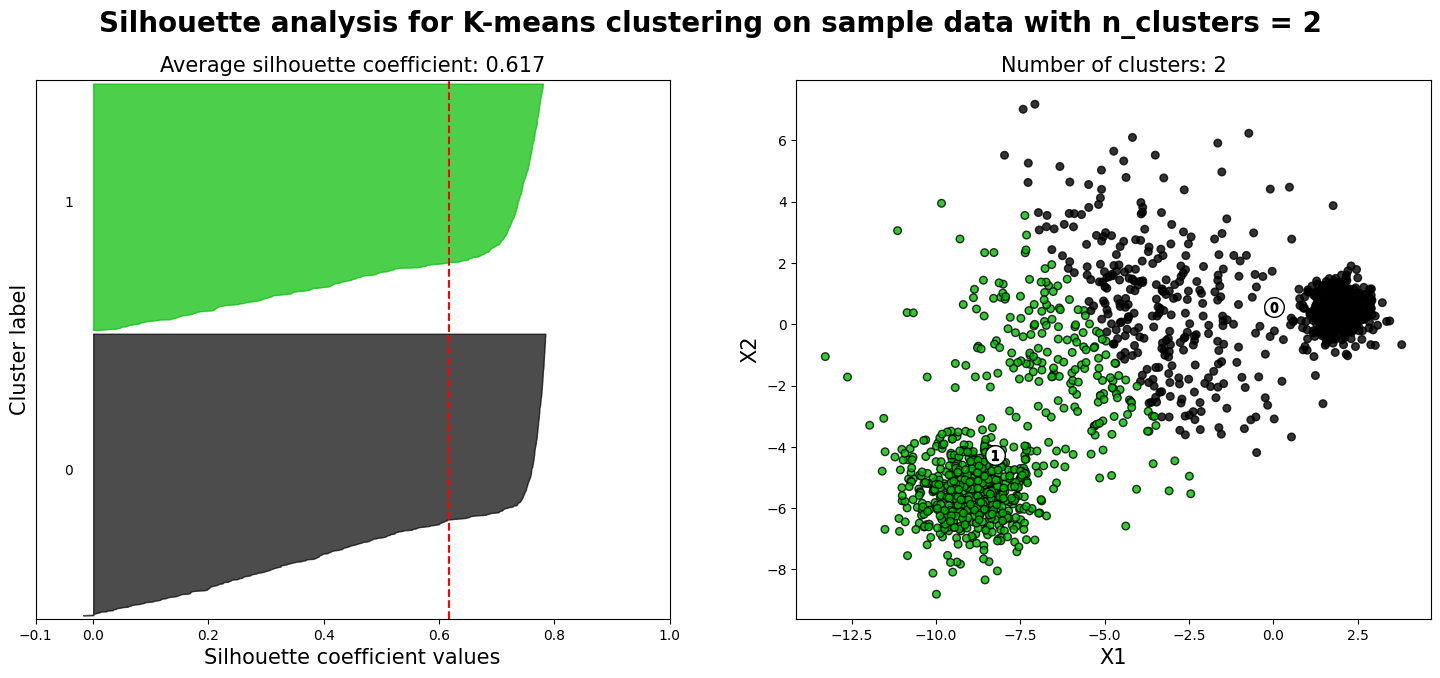

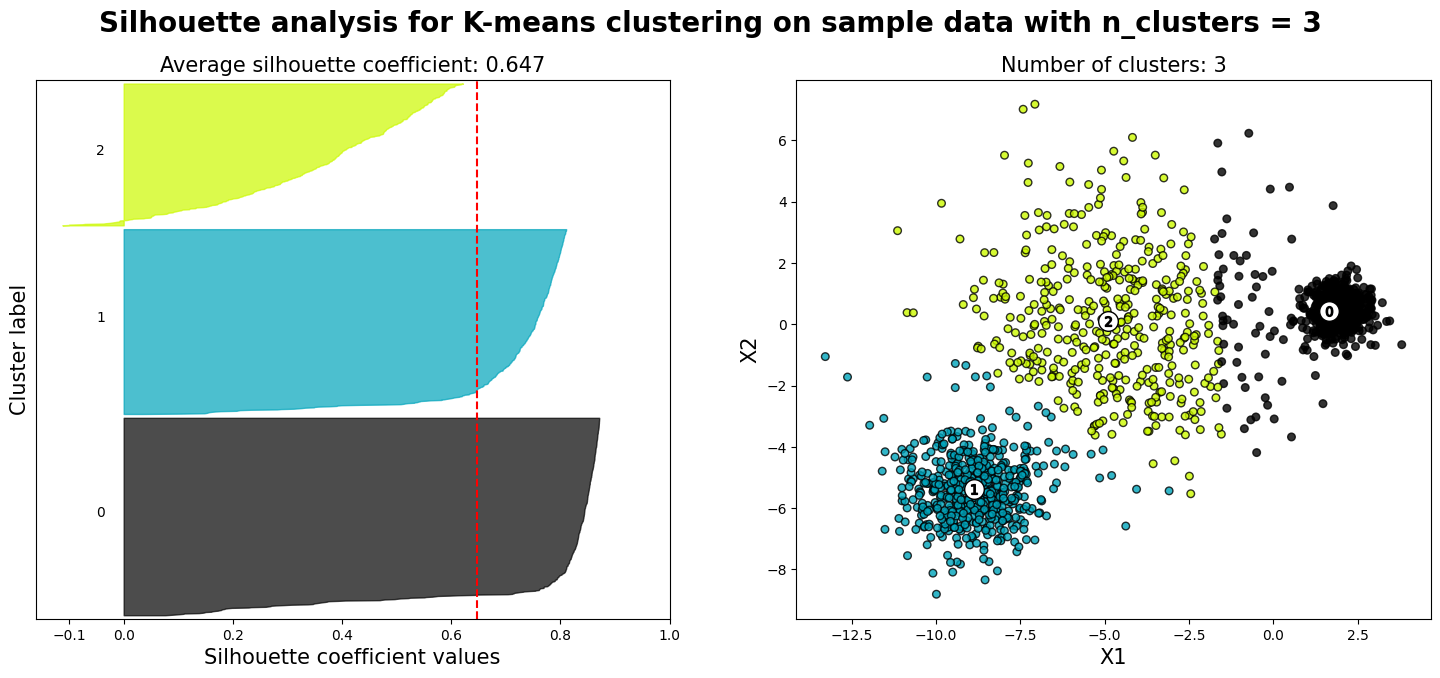

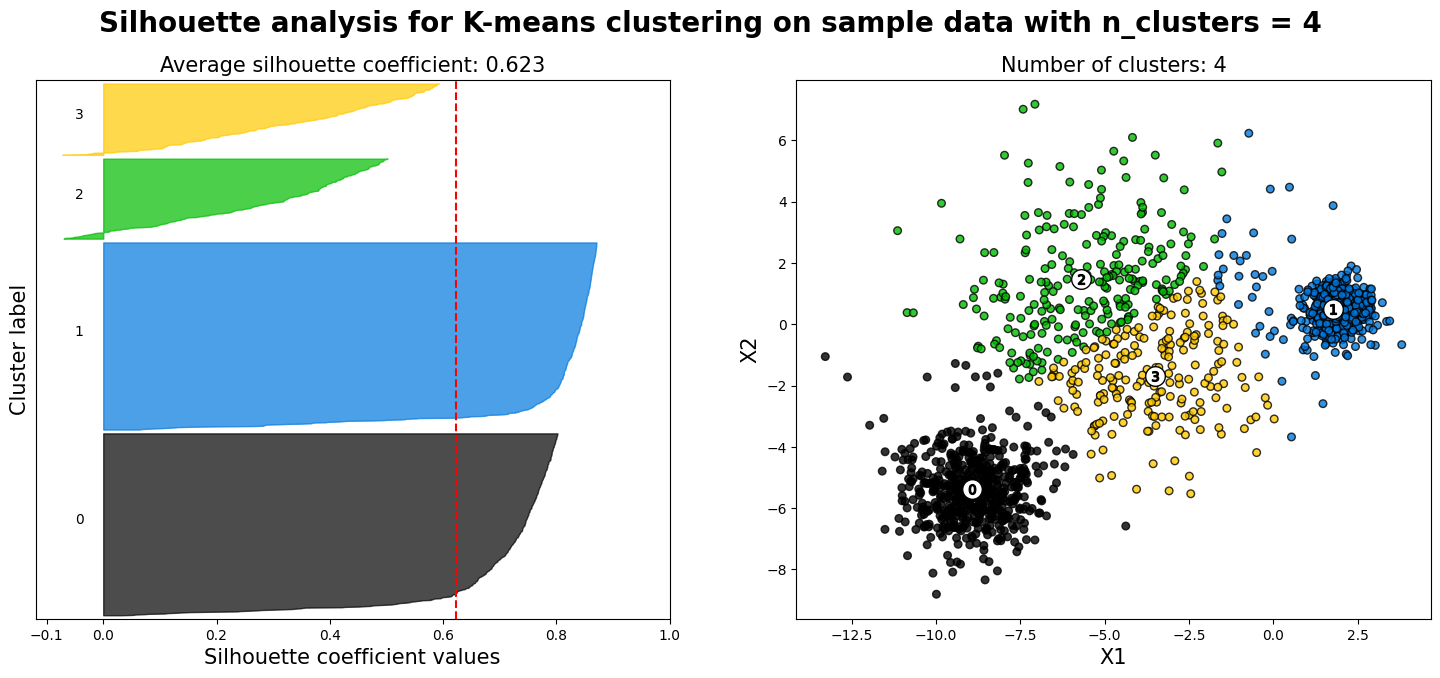

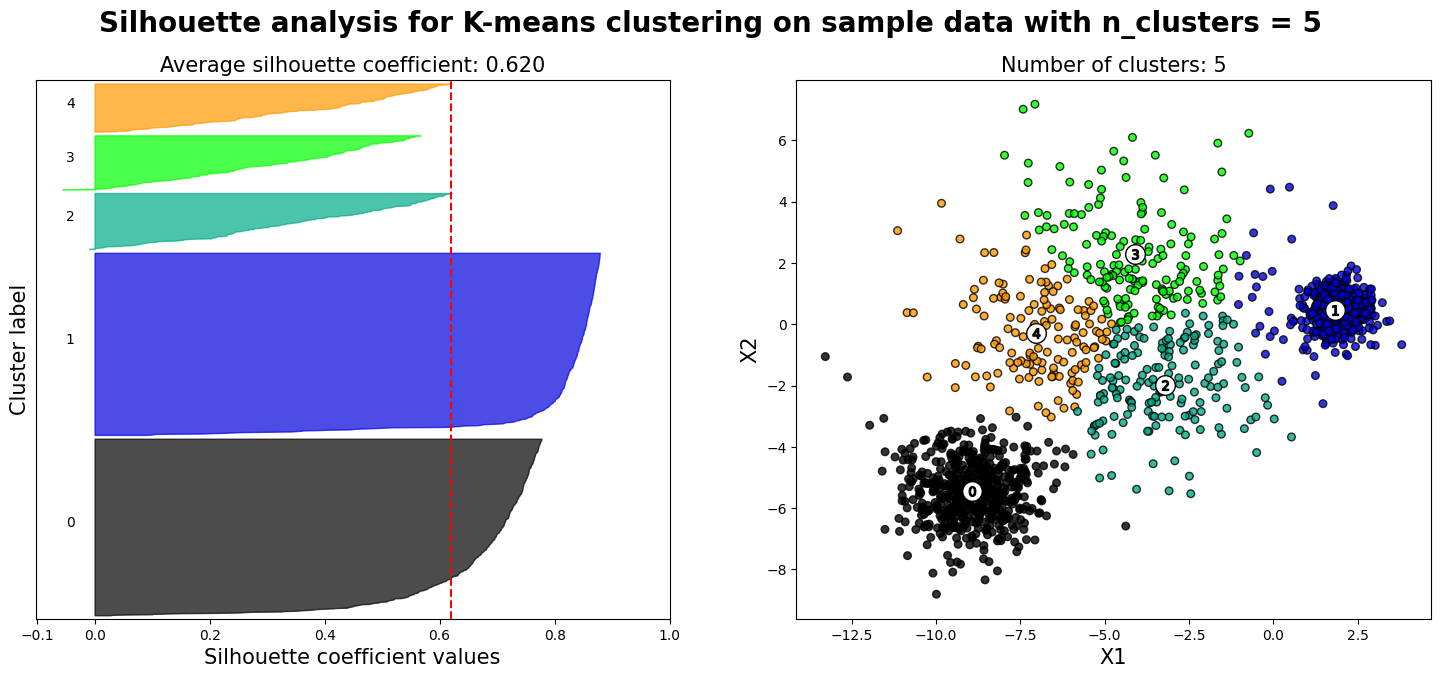

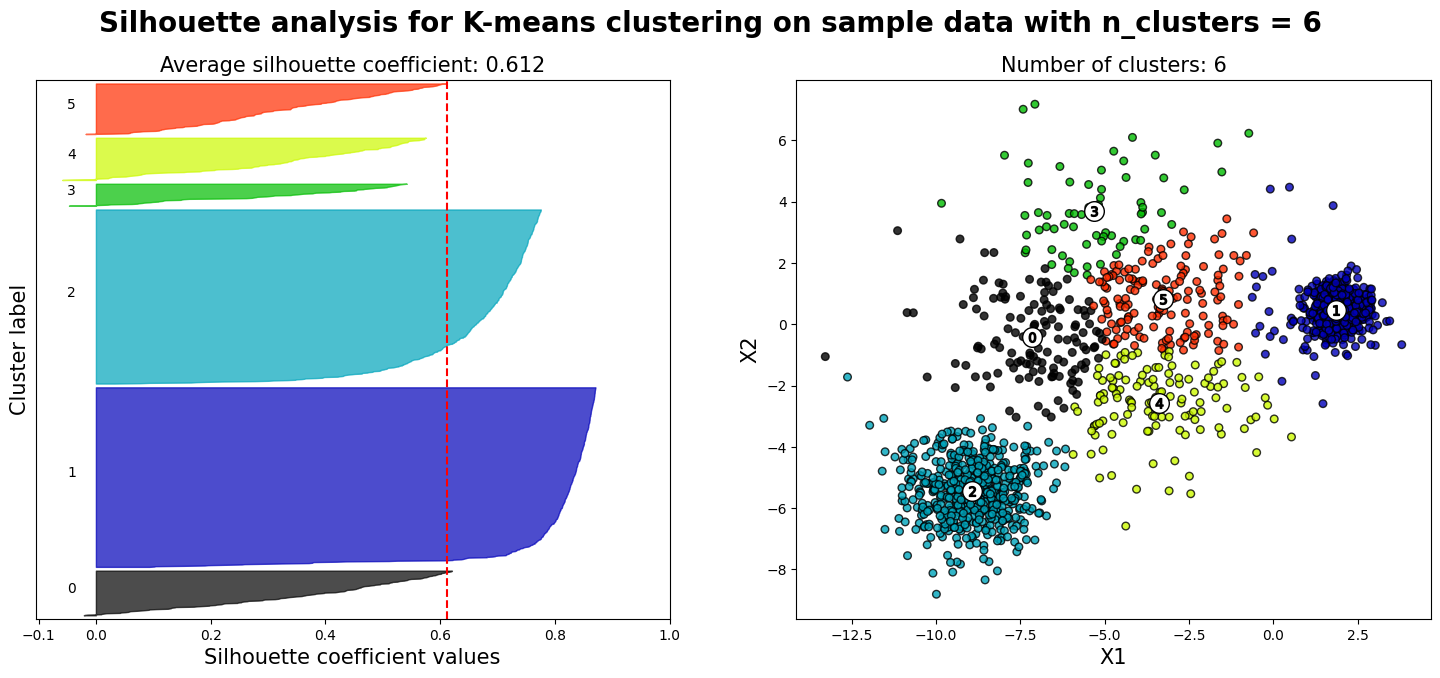

In [32]:
# get input values
X = df_blobs.loc[:, ["x1", "x2"]].values

# one silhouette plot for different numbers of clusters.
for n_clusters in range(2, 7):
    
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # demarcate silhouette plots of individual clusters by inserting blanck space
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # K-means clustering
    kmean = KMeans(
        n_clusters=n_clusters, init='k-means++', 
        n_init=10, max_iter=300, tol=0.0001, 
        verbose=0, random_state=13, 
        algorithm='elkan')
    cluster_labels = kmean.fit_predict(X)

    # compute average silhouette score
    score = silhouette_score(X, cluster_labels)

    # compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # plot silhouette scores for each sample
    y_lower = 10
    for i in range(n_clusters):
        
        # aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # axis labels and title
    ax1.set_title("Average silhouette coefficient: {0:0.3f}".format(score), fontsize=15)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=15)
    ax1.set_ylabel("Cluster label", fontsize=15)

    # draw a vertical line for average silhouette score of all the values
    ax1.axvline(x=score, color="red", linestyle="--")

    # clear the yaxis labels / ticks
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], 
                marker='o', s=30, alpha=0.8, c=colors, edgecolor='k')    
    
    # draw white circles at cluster centers
    centers = kmean.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    # axis labels and title
    ax2.set_title("Number of clusters: {0}".format(n_clusters), fontsize=15)
    ax2.set_xlabel("X1", fontsize=15)
    ax2.set_ylabel("X2", fontsize=15)

    # main title
    plt.suptitle(("Silhouette analysis for K-means clustering on sample data "
                  "with n_clusters = {0}".format(n_clusters)),
                 fontsize=20, fontweight='bold')

plt.show()

## Adjusted Rand Index

The Rand Adjusted Index is used to **comparison a clustering result with the true clusters**. For each pair of observations, we look to see if they are in the same cluster or not, in both predicted and real clustering. The index takes values between 0 (random clustering) and 1 (perfect clustering).

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

**Code:** Calculate the Rand fitted index for k-means clustering on Gaussian distributions.

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


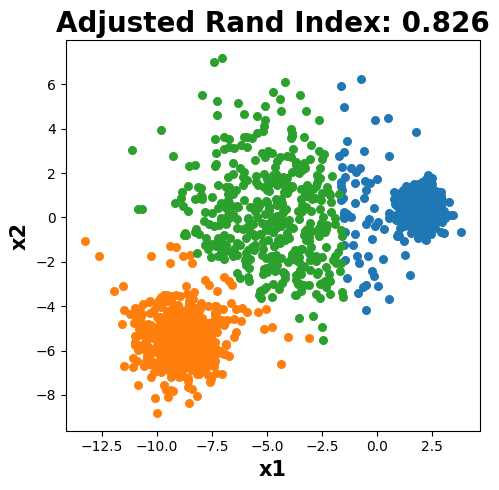

In [34]:
# clustering
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='elkan')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])

# update dataframe clusters
df_blobs.loc[:, "cluster"] = kmean.labels_

# compute Adjusted Rand Index
ari = adjusted_rand_score(
    labels_true=df_blobs.loc[:, "label"], 
    labels_pred=df_blobs.loc[:, "cluster"])

# plot
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Adjusted Rand Index: {0:0.3}".format(ari))

# 3 - Application

**Code:** Now try to maximize the Rand adjusted index on real penguin data.

- Don't forget that you can remove missing values from your database or impute them with `sklearn.impute.SimpleImputer`.
- You can search for the most relevant set of features for clustering penguin species, or keep the set of features and project them into a reduced-dimensional space with `sklearn.decomposition.PCA` (preceded by `sklearn.preprocessing.StandardScaler`).
- Choose the right clustering algorithm based on what we've just seen on the simulated data.
- Optimize the parameters of this algorithm using coefficients and silhouette graphs.
- Display the clusters you predict to make sure you're on the right track!

/tmp/ipykernel_95638/156654375.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=30, cmap="Paired", label=label)


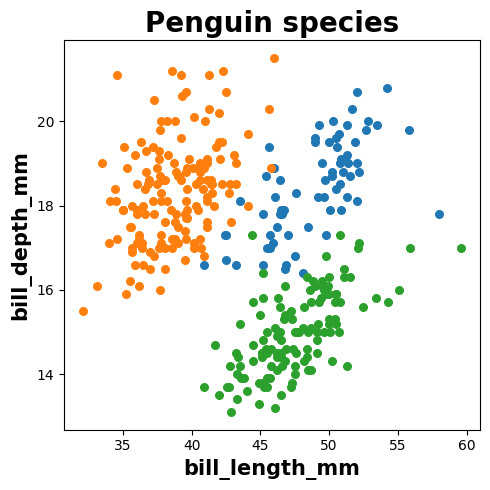

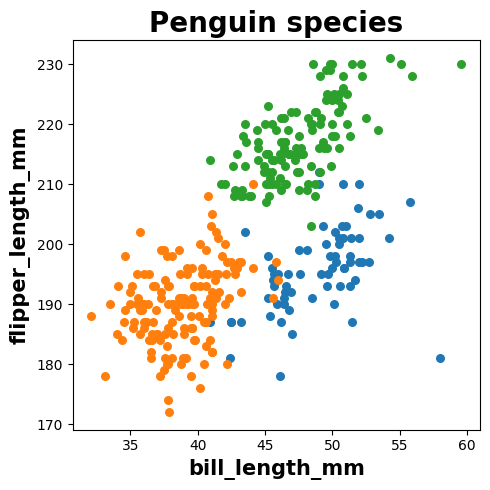

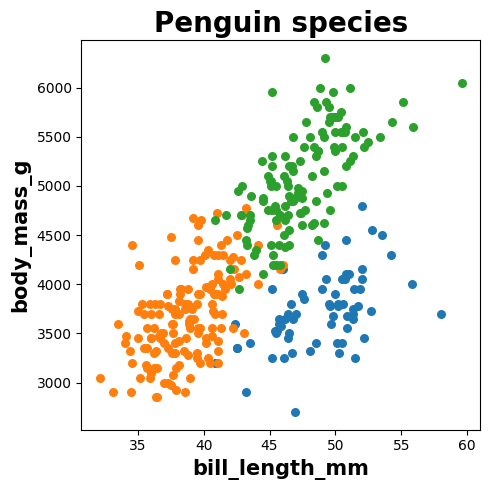

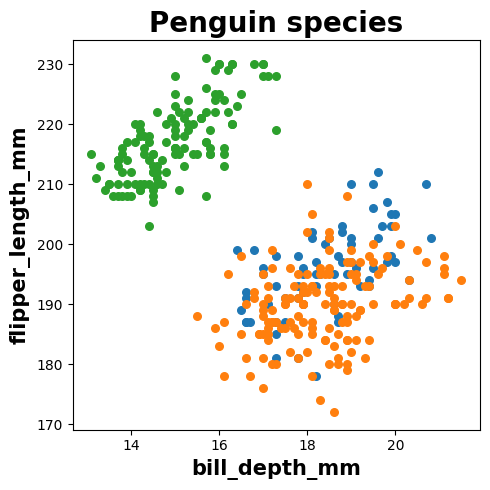

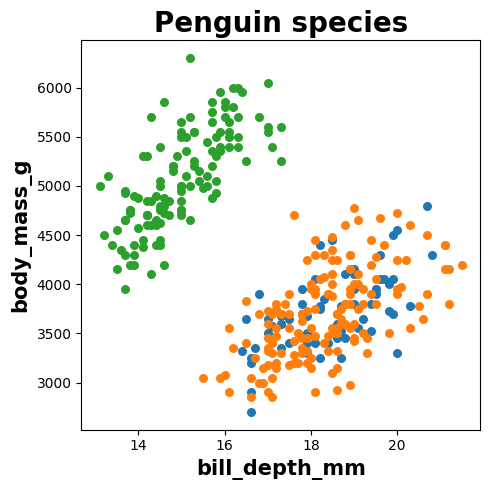

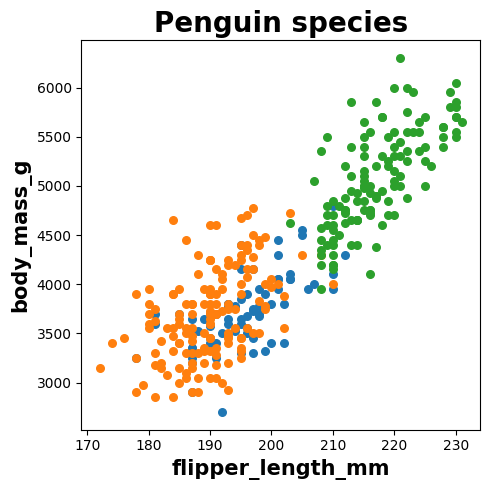

In [35]:
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_length_mm", 
                  feature_y="bill_depth_mm", 
                  feature_label="label",
                  title="Penguin species")
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_length_mm", 
                  feature_y="flipper_length_mm", 
                  feature_label="label",
                  title="Penguin species")
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_length_mm", 
                  feature_y="body_mass_g", 
                  feature_label="label",
                  title="Penguin species")
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_depth_mm", 
                  feature_y="flipper_length_mm", 
                  feature_label="label",
                  title="Penguin species")
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_depth_mm", 
                  feature_y="body_mass_g", 
                  feature_label="label",
                  title="Penguin species")
plot_point_clouds(data=df_penguin, 
                  feature_x="flipper_length_mm", 
                  feature_y="body_mass_g", 
                  feature_label="label",
                  title="Penguin species")

In [36]:
# get numerical values
values = df_penguin.loc[:, ["bill_length_mm", "body_mass_g"]].values
print(values.shape)

# impute missing values
imputer = SimpleImputer(strategy='mean')
values_imputed = imputer.fit_transform(values)
print(values_imputed.shape)
print(np.isnan(values_imputed).sum())

(344, 2)
(344, 2)
0


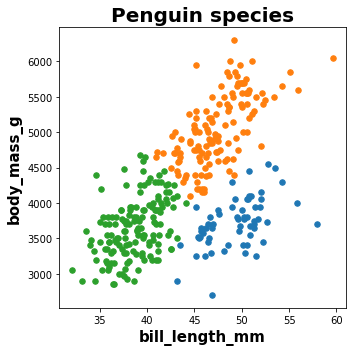

0.8419094467544075


In [30]:
# GMM
gmm = GaussianMixture(
    n_components=3, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(values_imputed)
df_penguin.loc[:, "cluster"] = gmm.predict(values_imputed)

# plot
plot_point_clouds(data=df_penguin, 
                  feature_x="bill_length_mm", 
                  feature_y="body_mass_g", 
                  feature_label="cluster",
                  title="Penguin species")

# compute Adjusted Rand Index
ari = adjusted_rand_score(
    labels_true=df_penguin.loc[:, "label"], 
    labels_pred=df_penguin.loc[:, "cluster"])
print(ari)